# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler

In [2]:
import pickle as pkl
from pathlib import Path
import numpy as np
import pandas as pd



ROOT_PATH = Path('/home/downloads/CarND-Traffic-Sign-Classifier-Project')

DATA_PATH = ROOT_PATH / 'data'
TRAIN_DATA_PATH = DATA_PATH / 'train.p'
TEST_DATA_PATH = DATA_PATH / 'test.p'
VALID_DATA_PATH = DATA_PATH / 'valid.p'

with open(TRAIN_DATA_PATH, 'rb') as f:
    train_data = pkl.load(f)
with open(VALID_DATA_PATH, 'rb') as f:
    valid_data = pkl.load(f)
with open(TEST_DATA_PATH, 'rb') as f:
    test_data = pkl.load(f)

print('keys', train_data.keys())

print(train_data['features'].shape)
print(valid_data['features'].shape)
print(test_data['features'].shape)

# sign names
sign_names = pd.read_csv(ROOT_PATH/'signnames.csv').to_dict()['SignName']

keys dict_keys(['coords', 'labels', 'features', 'sizes'])
(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = train_data['features'].shape[0]

# TODO: Number of validation examples
n_validation = valid_data['features'].shape[0]

# TODO: Number of testing examples.
n_test = test_data['features'].shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = train_data['features'].shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(train_data['labels']))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Total Images:", n_train + n_validation + n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Total Images: 51839
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import pandas as pd

#### Compare the distributions of labels

I compare the distribution of labels in both train and test datasets. The distrubtions are similar between these two datasets. 

In [5]:
x_train = train_data['features']
y_train = train_data['labels']
x_val = valid_data['features']
y_val = valid_data['labels']
x_train_val = np.concatenate((x_train, x_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)
x_test = test_data['features']
y_test = test_data['labels']

In [6]:
def get_label_counts(y, perc=True):
    y_df = pd.DataFrame(y, columns=['label'])
    yct = y_df.groupby(y_df.label).label.count()
    if perc:
        yct = yct / yct.sum()
    return yct.index.ravel(), yct.values.ravel()

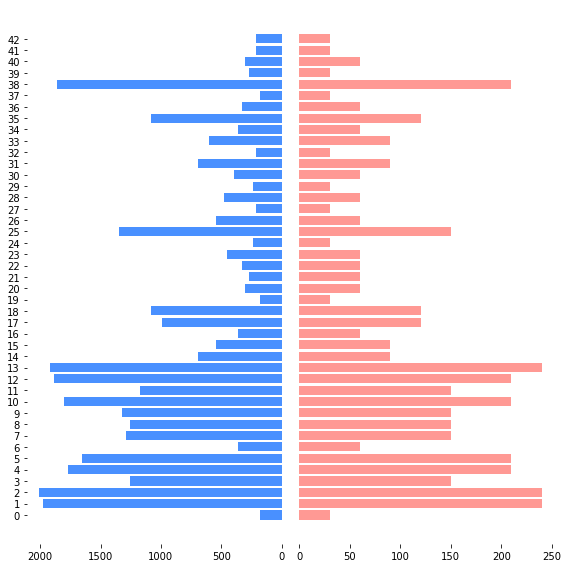

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax0 = axes[0]
yct_idx, yct_values = get_label_counts(y_train, False)
ax0.set_frame_on(False)
ax0.invert_xaxis()
#ax0.get_xaxis().set_visible(False)
ax0.barh(yct_idx.astype(str), yct_values, facecolor='#4990ff')

ax1 = axes[1]
yct_idx, yct_values = get_label_counts(y_val, False)
#ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.set_frame_on(False)
ax1.barh(yct_idx.astype(str), yct_values, facecolor='#ff9994')
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()

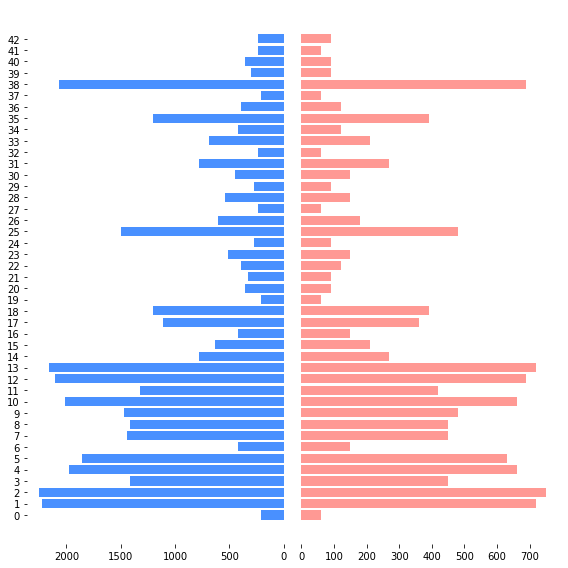

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax0 = axes[0]
yct_idx, yct_values = get_label_counts(y_train_val, False)
ax0.set_frame_on(False)
ax0.invert_xaxis()
#ax0.get_xaxis().set_visible(False)
ax0.barh(yct_idx.astype(str), yct_values, facecolor='#4990ff')

ax1 = axes[1]
yct_idx, yct_values = get_label_counts(y_test, False)
#ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.set_frame_on(False)
ax1.barh(yct_idx.astype(str), yct_values, facecolor='#ff9994')
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()

In [9]:
yct_idx, yct_values = get_label_counts(y_train, False)
np.sort(yct_values)

array([ 180,  180,  180,  210,  210,  210,  210,  240,  240,  270,  270,
        300,  300,  330,  330,  360,  360,  360,  390,  450,  480,  540,
        540,  599,  690,  690,  990, 1080, 1080, 1170, 1260, 1260, 1290,
       1320, 1350, 1650, 1770, 1800, 1860, 1890, 1920, 1980, 2010])

#### Check images

I sample some images from each category. This can help us understand the image conditions like perspective, contrast and lightness and help us develop augmentation strategy.

In [10]:
np.random.seed(100)

y_tv_df = pd.DataFrame({'labels': y_train_val})

NUM_SAMPLES = 5
sample_idx = list(y_tv_df
     .reset_index()
     .groupby(y_tv_df.labels)
     .labels
     .apply(lambda x: x.sample(NUM_SAMPLES))
     .to_dict()
     .keys()
)

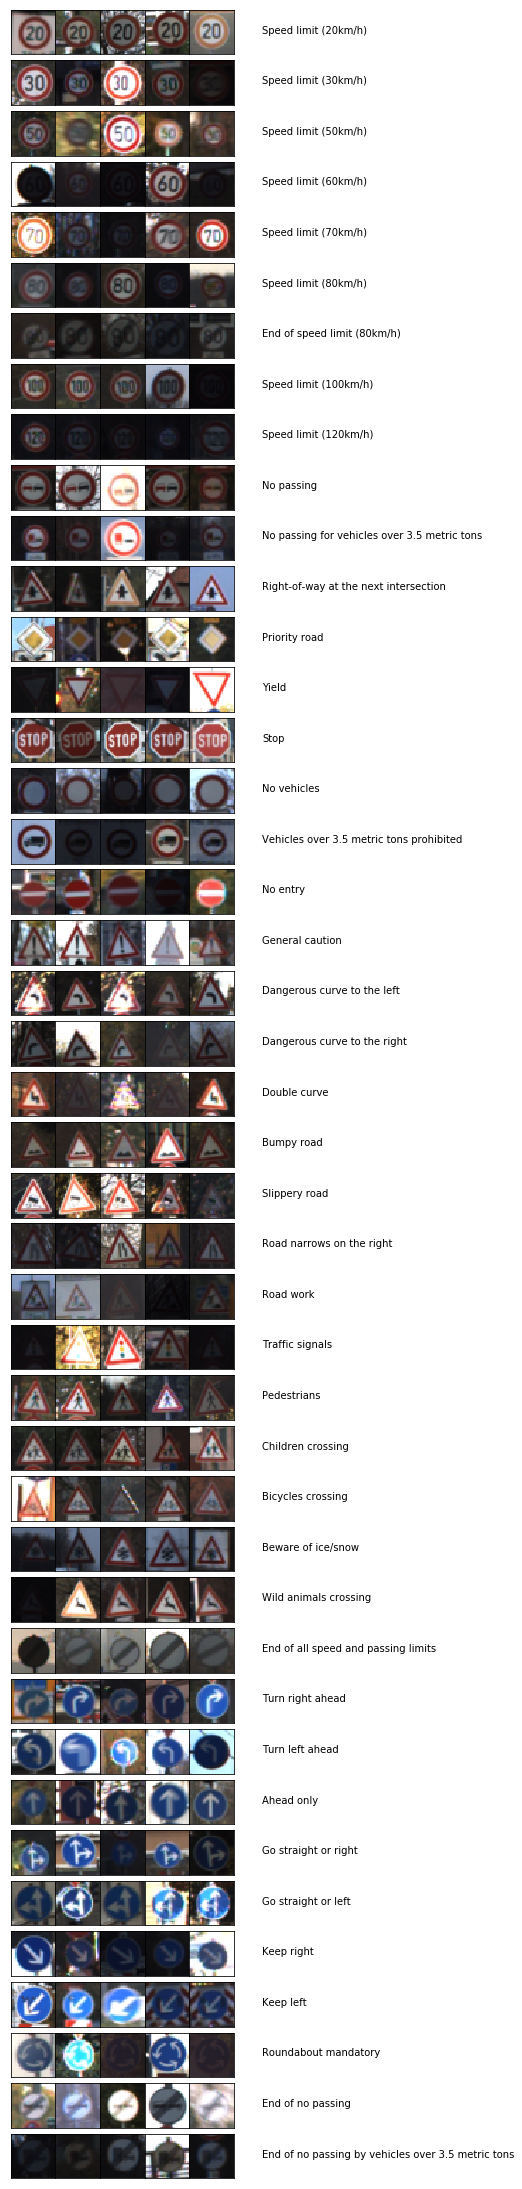

In [11]:
fig, axes = plt.subplots(43, NUM_SAMPLES, figsize=(4,40), squeeze=True)

for i, ax in enumerate(axes.flat):
    label, img_id = sample_idx[i]
    ax.imshow(x_train_val[img_id])
    if i % 5 == 0:
        #ax.set_ylabel(label)
        #ax.get_yaxis().set_visible(False)
        ax.text(180, 16, sign_names[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [12]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

In [13]:
from fastai.transforms import *
from fastai.dataset import ImageClassifierData, tfms_from_model
from fastai.conv_learner import resnet18

PATH = '/home/downloads/CarND-Traffic-Sign-Classifier-Project/data/'

x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
x_val = x_val.astype(np.float32)
y_val = y_val.astype(np.float32)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [14]:
#Calculate mean and std for normalization
def glo_m_s(x):
    print(f'shape of x_train is {x_train.shape}')
    glo_mean = np.zeros(3)
    glo_std = np.zeros(3)
    for i in range(3):
        glo_mean[i] = x[:, :, :, i].mean()
        glo_std[i] = x[:, :, :, i].std()

    glo_mean = glo_mean / 255
    glo_std = glo_std / 255
    return glo_mean, glo_std

def norm_img(x):
    return x/255

def denorm_img(x, as_int=True):
    result=x*255
    if as_int:
        result = result.astype(np.int)
    return result

def denorm_imshow(x, dl):
    x = dl.trn_ds.transform.denorm(to_np(x).transpose(1,2,0))
    return denorm_img(x)

In [15]:
glo_mean, glo_std = glo_m_s(x_train)

x_train_nm = norm_img(x_train)
x_val_nm = norm_img(x_val)
x_test_nm = norm_img(x_test)

shape of x_train is (34799, 32, 32, 3)


In [32]:
augs = [
    RandomLighting(0.05, 0.5), 
    RandomBlur(3), 
    RandomRotateZoom(20, 0.1, 0.2, ps=[0.25, 0.3, 0.3, 0.15]),
    AddPadding(5)
]

#f_model = resnet18
sz=32
bs=64

In [33]:
tfms = tfms_from_stats((glo_mean, glo_std), 32, augs)

In [34]:
BS = 36
NUM_ROWS = 6
dl = ImageClassifierData.from_arrays(PATH, 
                                       (x_train_nm, y_train),
                                       (x_val_nm, y_val),
                                       bs=BS,
                                       tfms=tfms,
                                       num_workers=12)

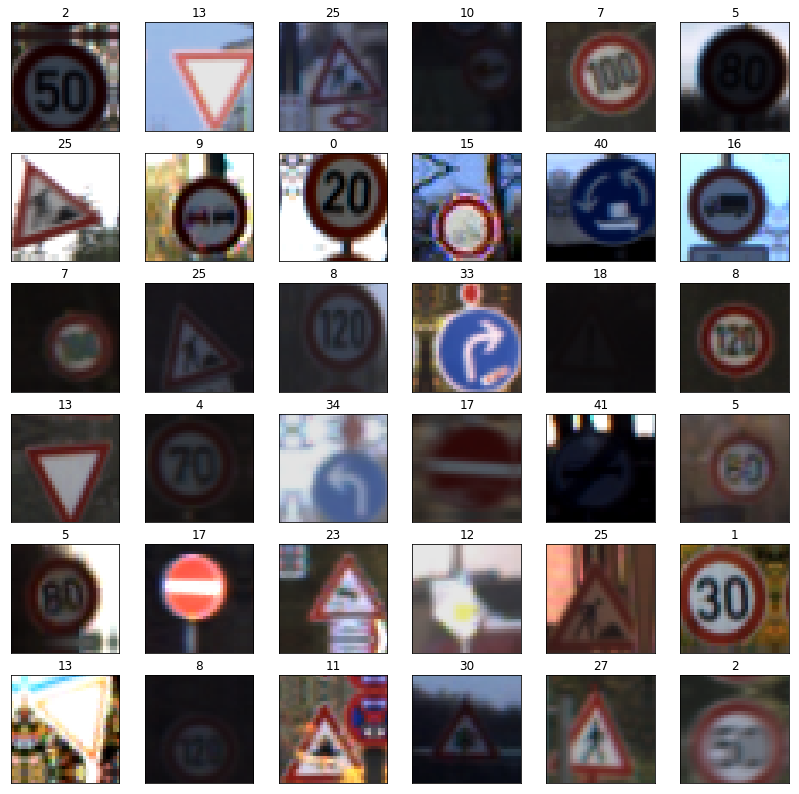

In [35]:
xs, ys = next(iter(dl.trn_dl))
fig, axes = plt.subplots(int(NUM_ROWS), int(BS/NUM_ROWS), figsize=(14, 14))
for i, ax in enumerate(axes.flat):
    ax.imshow(denorm_imshow(xs[i], dl))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(to_np(ys).astype(np.int)[i])

### Model Architecture

In [20]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [21]:
# adpated from https://github.com/kuangliu/pytorch-cifar
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 43)
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [22]:
# adapted from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2], 43)   

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3], 43)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [23]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [29]:
def train(train_loader, net, epoch, device, optimizer, loss_func):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        targets = targets.type(torch.LongTensor)
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        #pdb.set_trace()
        loss = loss_func(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

        _, prediction = outputs.max(1)
        total += targets.size(0)
        correct += prediction.eq(targets).sum().item()
        
    return train_loss, correct, total

def test(test_loader, net, epoch, device, loss_func, train_loss=None, correct_train=None, total_train=None):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    best_acc = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            targets = targets.type(torch.LongTensor)
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = loss_func(outputs, targets)
            test_loss += loss.item()
            _, prediction = outputs.max(1)
            total += targets.size(0)
            correct += prediction.eq(targets).sum().item()

    if train_loss is None:
        print(f'{epoch}\t {batch_idx}\t {len(test_loader)}\t', 
                f'Test  Loss: {test_loss/(batch_idx+1):.3f}\t',
                f' Acc: {100.*correct/total:.3f}%\t',
                f' ({correct}/{total})')
    else:
        print(f'{epoch}\t {batch_idx}\t {len(test_loader)}\t',
        f'Train Loss: {train_loss/(batch_idx+1):.3f}\t',
        f' Acc: {100.*correct_train/total_train:.3f}%\t',
        #f' ({correct_train}/{total_train})'
        f'Test Loss: {test_loss/(batch_idx+1):.3f}\t',
        f' Acc: {100.*correct/total:.3f}%\t')

def eval_test(model_name, device):
    dl = ImageClassifierData.from_arrays(
        PATH, 
       (x_train_nm, y_train),
       (x_val_nm, y_val),
       #bs=x_test_nm.shape[0],
       bs=64,
       tfms=tfms,
       num_workers=1, 
       test=(x_test_nm, y_test))

    net = torch.load(ROOT_PATH/f'checkpoint/{model_name}.t7')['model']

    loss_func = nn.CrossEntropyLoss()

    test(dl.test_dl, net, 1, device, loss_func)

def main(dl, net, root_path, model_name=None, lr=0.001, weight_decay=5e-4, num_epochs=10, milestones=None):
    
    device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
    print(f'device: {device}')
    start_epoch = 0
    
    train_loader = dl.trn_dl
    val_loader = dl.val_dl
    
    if device == 'cuda:1':
        #net = torch.nn.DataParallel(net)
        net = net.cuda(1)
        cudnn.benchmark = True
    
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    if milestones is None: 
        milestones = [int(num_epochs/2)]
    exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
    #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer)
    for epoch in range(start_epoch, start_epoch+num_epochs):
        exp_lr_scheduler.step()
        train_loss, correct, total = train(train_loader, net, epoch, device, optimizer, loss_func)
        test(val_loader, net, epoch, device, loss_func, train_loss, correct, total)
    
    # save final model
    state_dict = {
        'model': net,
        'optimizer': optimizer
    }
    test(val_loader, net, epoch, device, loss_func)
    checkpoint_path = root_path/'checkpoint'
    model_path = checkpoint_path/f'{model_name}.t7'
    if not checkpoint_path.exists():
        checkpoint_path.mkdir()
    if model_name is not None:
        torch.save(state_dict, str(model_path))

In [30]:
dl = ImageClassifierData.from_arrays(
    PATH, 
    (x_train_nm, y_train),
    (x_val_nm, y_val),
    bs=256,
    tfms=tfms,
    num_workers=12,
    test=(x_test_nm, y_test))

In [ ]:
%%time
# lenet
net = LeNet()
main(dl, net, ROOT_PATH, 'lenet', lr=5e-3, num_epochs=50, milestones=[40])

> 49	 17	 18	 Test  Loss: 0.249	  Acc: 94.989%	  (4189/4410)

In [89]:
eval_test('lenet', 'cuda:0')

1	 197	 198	 Test  Loss: 0.270	  Acc: 94.972%	  (11995/12630)


In [ ]:
%%time
net = ResNet18()
main(dl, net, ROOT_PATH, 'resnet18-2', lr=1e-3, num_epochs=50, milestones=[30, 40])

device: cuda:1
0	 17	 18	 Train Loss: 13.889	  Acc: 44.478%	 Test Loss: 1.209	  Acc: 60.884%	
1	 17	 18	 Train Loss: 1.861	  Acc: 92.850%	 Test Loss: 0.199	  Acc: 95.011%	
2	 17	 18	 Train Loss: 0.611	  Acc: 97.865%	 Test Loss: 0.276	  Acc: 90.635%	
3	 17	 18	 Train Loss: 0.435	  Acc: 98.555%	 Test Loss: 0.364	  Acc: 90.249%	
4	 17	 18	 Train Loss: 0.387	  Acc: 98.692%	 Test Loss: 0.534	  Acc: 84.580%	
5	 17	 18	 Train Loss: 0.335	  Acc: 98.911%	 Test Loss: 0.217	  Acc: 93.923%	
6	 17	 18	 Train Loss: 0.283	  Acc: 99.178%	 Test Loss: 0.127	  Acc: 97.211%	
7	 17	 18	 Train Loss: 0.287	  Acc: 99.138%	 Test Loss: 0.094	  Acc: 97.370%	
8	 17	 18	 Train Loss: 0.235	  Acc: 99.299%	 Test Loss: 0.761	  Acc: 77.438%	
9	 17	 18	 Train Loss: 0.271	  Acc: 99.195%	 Test Loss: 0.154	  Acc: 97.166%	
10	 17	 18	 Train Loss: 0.200	  Acc: 99.420%	 Test Loss: 0.121	  Acc: 97.392%	
11	 17	 18	 Train Loss: 0.245	  Acc: 99.204%	 Test Loss: 0.133	  Acc: 96.463%	
12	 17	 18	 Train Loss: 0.199	  Acc: 99.448%	 

In [79]:
%%time
net = ResNet18()
main(dl, net, ROOT_PATH, 'resnet18', lr=1e-3, num_epochs=50, milestones=[30, 40])

device: cuda
0	 122	 123	 Train Loss: 11.463	  Acc: 56.800%	 Test Loss: 0.311	  Acc: 92.222%	
1	 122	 123	 Train Loss: 1.477	  Acc: 94.549%	 Test Loss: 0.621	  Acc: 81.859%	
2	 122	 123	 Train Loss: 0.922	  Acc: 96.644%	 Test Loss: 0.204	  Acc: 93.628%	
3	 122	 123	 Train Loss: 0.717	  Acc: 97.514%	 Test Loss: 0.095	  Acc: 97.914%	
4	 122	 123	 Train Loss: 0.605	  Acc: 98.029%	 Test Loss: 0.110	  Acc: 96.531%	
5	 122	 123	 Train Loss: 0.535	  Acc: 98.215%	 Test Loss: 0.089	  Acc: 98.050%	
6	 122	 123	 Train Loss: 0.503	  Acc: 98.422%	 Test Loss: 0.089	  Acc: 97.574%	
7	 122	 123	 Train Loss: 0.421	  Acc: 98.724%	 Test Loss: 0.075	  Acc: 98.141%	
8	 122	 123	 Train Loss: 0.448	  Acc: 98.566%	 Test Loss: 0.119	  Acc: 96.735%	
9	 122	 123	 Train Loss: 0.380	  Acc: 98.885%	 Test Loss: 0.052	  Acc: 98.571%	
10	 122	 123	 Train Loss: 0.392	  Acc: 98.759%	 Test Loss: 0.096	  Acc: 97.937%	
11	 122	 123	 Train Loss: 0.358	  Acc: 98.928%	 Test Loss: 0.141	  Acc: 96.621%	
12	 122	 123	 Train Loss

/home/user/miniconda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/user/miniconda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type BasicBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 19min 50s, sys: 20min 48s, total: 40min 38s
Wall time: 29min 47s


> 49	 122	 123	 Test  Loss: 0.024	  Acc: 99.297%	  (4379/4410)

In [117]:
eval_test('resnet18', 'cuda:0')

1	 197	 198	 Test  Loss: 0.044	  Acc: 98.741%	  (12471/12630)


In [40]:
eval_test('resnet18', 'cuda:0')

1	 197	 198	 Test  Loss: 0.034	  Acc: 99.089%	  (12515/12630)


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

In [57]:
TEST_PATH = ROOT_PATH/'test_images'

In [58]:
import cv2
from skimage.transform import resize

def resize_image(img):
    return resize(img, (32, 32), anti_aliasing=True, mode='constant')

/home/downloads/CarND-Traffic-Sign-Classifier-Project/test_images/ex2.jpg


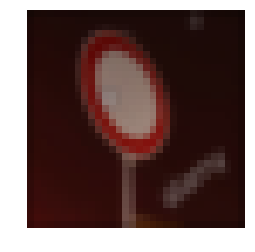

/home/downloads/CarND-Traffic-Sign-Classifier-Project/test_images/ex6.jpg


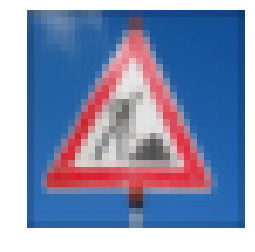

/home/downloads/CarND-Traffic-Sign-Classifier-Project/test_images/ex8.jpg


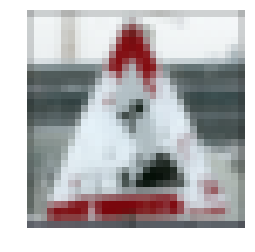

/home/downloads/CarND-Traffic-Sign-Classifier-Project/test_images/ex7.jpg


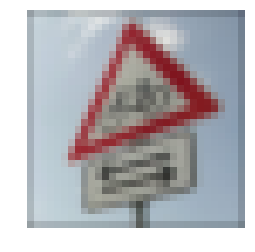

/home/downloads/CarND-Traffic-Sign-Classifier-Project/test_images/ex1.jpg


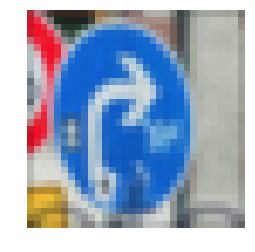

/home/downloads/CarND-Traffic-Sign-Classifier-Project/test_images/ex5.jpg


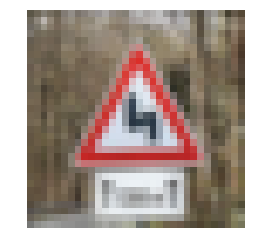

/home/downloads/CarND-Traffic-Sign-Classifier-Project/test_images/ex3.jpg


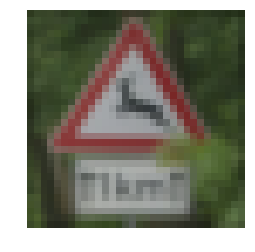

/home/downloads/CarND-Traffic-Sign-Classifier-Project/test_images/ex4.jpg


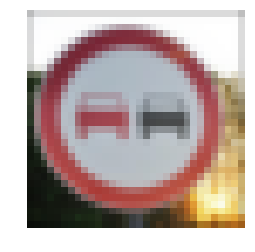

In [59]:
new_imgs = []
files_list = [x for x in TEST_PATH.iterdir() if x.suffix == '.jpg']
for pth in files_list:
    print(pth)
    img = plt.imread(pth)
    img = resize_image(img)
    img_nm = norm_img(img)
    new_imgs.append(img)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

### Predict the Sign Type for Each Image

In [29]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

In [103]:
net = torch.load(ROOT_PATH/'checkpoint/resnet18.t7')['model']

In [104]:
res_nm = torch.Tensor(np.array(new_imgs).transpose(0, 3, 1, 2)).cuda()

In [105]:
res = net(res_nm)

In [106]:
preds_1 = res.argmax(dim=1).cpu().numpy()

In [107]:
[sign_names[x] for x in preds_1]

['No vehicles',
 'Road work',
 'Road work',
 'Bicycles crossing',
 'Turn right ahead',
 'Double curve',
 'Wild animals crossing',
 'No passing']

### Analyze Performance

In [36]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

In [37]:
print(f'Accuracy: {7/8.*100:.2f}%')

Accuracy: 87.50%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [38]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

In [39]:
preds_5 = res.topk(5, largest=True, sorted=True)[1].cpu().numpy()

In [40]:
for xs in preds_5:
    res5 = []
    for x in xs:
        res5.append(sign_names[x])
    print(res5)

['Yield', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Speed limit (60km/h)', 'Ahead only']
['Road work', 'Wild animals crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Double curve']
['Speed limit (30km/h)', 'Go straight or left', 'Road work', 'General caution', 'Keep right']
['No passing', 'Priority road', 'End of all speed and passing limits', 'No passing for vehicles over 3.5 metric tons', 'Slippery road']
['Turn left ahead', 'Ahead only', 'Dangerous curve to the right', 'End of no passing', 'Go straight or right']
['Wild animals crossing', 'Speed limit (30km/h)', 'Speed limit (20km/h)', 'Right-of-way at the next intersection', 'General caution']
['Wild animals crossing', 'Speed limit (120km/h)', 'Roundabout mandatory', 'Speed limit (20km/h)', 'Speed limit (70km/h)']
['No passing', 'End of no passing', 'Keep right', 'Speed limit (50km/h)', 'No passing for vehicles over 3.5 metric tons']


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [1]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

In [234]:
net = torch.load(ROOT_PATH/'checkpoint/lenet.t7')['model']
net = net.cuda(0)

dl = ImageClassifierData.from_arrays(
    PATH, 
   (x_train_nm, y_train),
   (x_val_nm, y_val),
   #bs=x_test_nm.shape[0],
   bs=64,
   tfms=tfms,
   num_workers=1, 
   test=(x_test_nm, y_test)) 

In [236]:
inputs, targets = next(iter(dl.test_dl))

In [237]:
device = 'cuda:0'
img_nm, label = inputs[0].to(device), targets[0].to(device)
img = denorm_imshow(img_nm, dl)

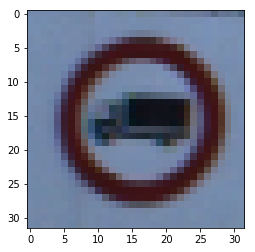

In [238]:
plt.imshow(img)

layer: Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)), fp shape: torch.Size([1, 6, 28, 28])


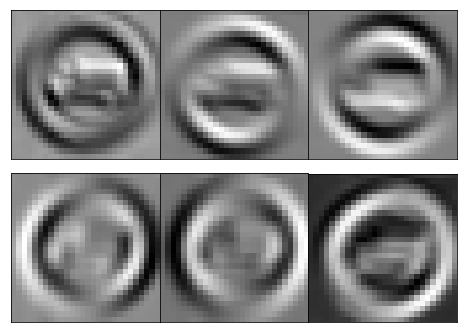

layer: Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)), fp shape: torch.Size([1, 16, 24, 24])


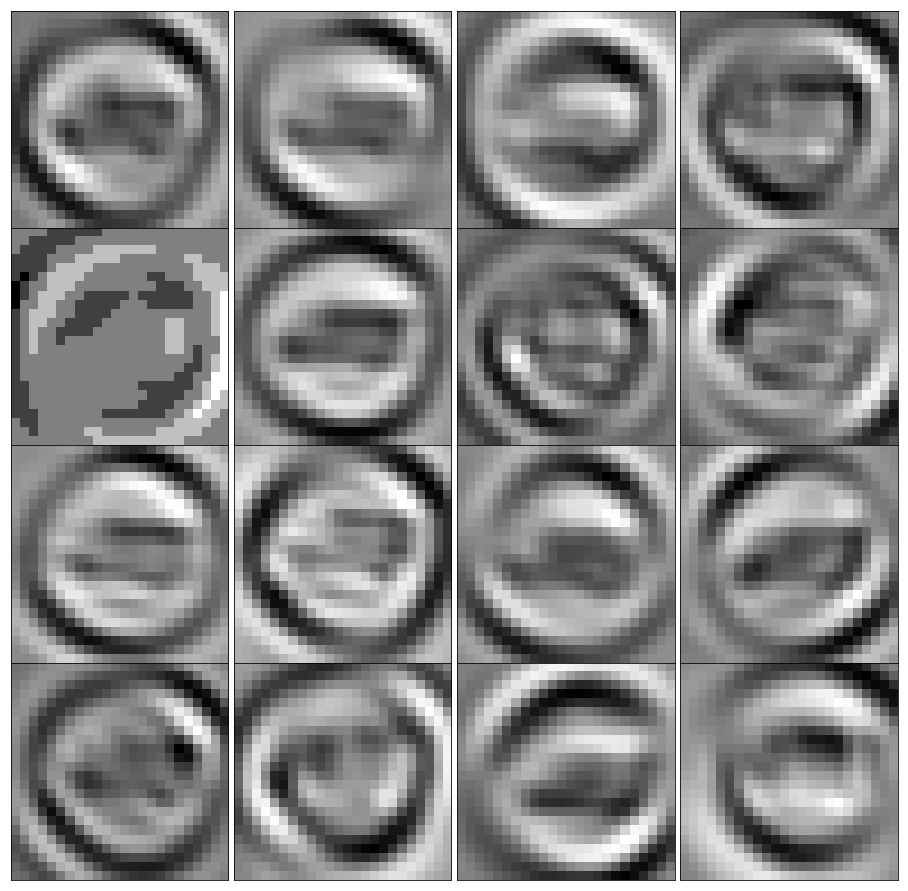

In [264]:
# set the feature maps to inputs
fms = img_nm.unsqueeze(0)
for md in list(net.modules())[2:4]:
    # get feature maps after that conv layer
    fms = md(fms)
    print(f'layer: {md}, fp shape: {fms.shape}')
    fms_np = fms.data.squeeze().cpu().numpy()
    if len(fms_np) == 6:
        nrows = 2
        ncols = 3
        figsize=(8, 6)
    elif len(fms_np) == 16:
        nrows = 4
        ncols = 4
        figsize=(16, 16)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        img = denorm_img(fms_np[i])
        ax.imshow(img, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()